In [13]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
import tensorflow_addons as tfa
from tensorflow.python.client import device_lib 

In [14]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  4


In [15]:
physical_devices = tf.config.list_physical_devices('GPU') 

In [16]:
tf.config.set_visible_devices(
    physical_devices[1], 'GPU'
)

# Data Loading 

Data pre-processing details:

* A 224×224 crop is randomly sampled from an image or its horizontal flip, with the per-pixel mean subtracted

Data augmentation:

*  Random RGB colour shift.

In [17]:
path_train = 'CINIC10/train/'
path_valid = 'CINIC10/valid/'
path_test = 'CINIC10/test/'
data_dir_train = pathlib.Path(path_train)
data_dir_val = pathlib.Path(path_valid)
data_dir_test = pathlib.Path(path_test)

In [18]:
list_ds_train = tf.data.Dataset.list_files(str(data_dir_train/'*/*'))
list_ds_val = tf.data.Dataset.list_files(str(data_dir_val/'*/*'))
list_ds_test = tf.data.Dataset.list_files(str(data_dir_test/'*/*'))

In [19]:
CLASS_NAMES = np.array([item.name for item in data_dir_train.glob('*')])

In [20]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == CLASS_NAMES

In [21]:
def decode_img(img,dsize):
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return tf.image.resize(img, [dsize[0], dsize[1]])

In [22]:
def process_path(file_path):
    size = (224,224)
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img,size )
    return img, label

In [23]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [24]:
labeled_ds_train = list_ds_train.map(process_path, num_parallel_calls=AUTOTUNE)
labeled_ds_valid = list_ds_val.map(process_path, num_parallel_calls=AUTOTUNE)
labeled_ds_test = list_ds_test.map(process_path, num_parallel_calls=AUTOTUNE)

In [25]:
def normalize(x, y):
    x = tf.image.per_image_standardization(x)
    return x, y

In [26]:
def augmentation(x, y):
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_brightness(x, max_delta=0.5)
    x = tf.image.random_contrast(x, lower=0.2, upper=1.8)
    return x, y

In [27]:
def prepare_for_training(ds, training = False, cache=True, shuffle_buffer_size=1000, batch_size = 128):
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
    ds = ds.map(normalize)
    if training:
        ds = ds.map(augmentation)
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [30]:
train_ds = prepare_for_training(labeled_ds_train, training= True, batch_size=64)
val_ds = prepare_for_training(labeled_ds_valid, batch_size=64)
test_ds = prepare_for_training(labeled_ds_test, batch_size=64)

# ResNet Details

* This architecture introduces skip connection
* optimizer = SGD 
* batch_size = 256 
* momentum = 0.9 
* weight decay = 0.0001 
* lr_initial = 0.1 (divided by ten when the error plateaus) 
* num_epochs = 74
* cross-entropy loss 
* do not use dropout

# Model Definition

In [33]:
def initial_block(inputs):
    kernel_init = tf.keras.initializers.GlorotNormal()
    x = tf.keras.layers.Conv2D(64, kernel_size=7, kernel_initializer = kernel_init, strides=2, padding='valid')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2)(x)
    return x

In [34]:
def basic_block(x, num_channels, strides=1):
    kernel_init = tf.keras.initializers.GlorotNormal()
    skip = x
    if strides == 2:
        skip = tf.keras.layers.Conv2D(num_channels, kernel_size=1, kernel_initializer = kernel_init, strides = 2)(skip)
    x = tf.keras.layers.Conv2D(num_channels, kernel_size=3, kernel_initializer = kernel_init, strides=strides, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv2D(num_channels, kernel_size=3, kernel_initializer = kernel_init, strides=1, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Add()([skip, x])
    x = tf.keras.layers.ReLU()(x)
    return x

In [35]:
def final_block(x, n_classes):
    x = tf.keras.layers.AveragePooling2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1000, activation='relu')(x)
    x = tf.keras.layers.Dense(n_classes, activation='softmax')(x)
    return x

In [36]:
def model(num_classes = 1000):
    inputs = tf.keras.layers.Input(shape = (224,224,3))
    x = initial_block(inputs)
    x = basic_block(x, 64)
    x = basic_block(x, 64)
    x = basic_block(x, 128, strides=2)
    x = basic_block(x, 128)
    x = basic_block(x, 256, strides=2)
    x = basic_block(x, 256)
    x = basic_block(x, 512, strides=2)
    x = basic_block(x, 512)
    x = final_block(x, num_classes)
    model = tf.keras.Model(inputs, x)
    return model

In [37]:
model_ = model(10)

In [38]:
model_.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 109, 109, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 109, 109, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 109, 109, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

# Training 

In [39]:
model_.compile(optimizer = tfa.optimizers.SGDW(momentum=0.9, weight_decay = 0.0001, learning_rate = 0.01),
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

In [40]:
history = model_.fit(train_ds,
                     epochs = 74,
                     steps_per_epoch = 100,
                     verbose = 1,
                     validation_data= val_ds,
                     validation_steps= 100)

Train for 100 steps, validate for 100 steps
Epoch 1/74
100/100 [==============================] - 18s 179ms/step - loss: 2.2822 - accuracy: 0.2177 - val_loss: 2.1953 - val_accuracy: 0.2020
Epoch 2/74
100/100 [==============================] - 12s 123ms/step - loss: 1.9620 - accuracy: 0.2683 - val_loss: 1.8443 - val_accuracy: 0.3212
Epoch 3/74
100/100 [==============================] - 12s 121ms/step - loss: 1.8712 - accuracy: 0.3044 - val_loss: 1.7767 - val_accuracy: 0.3458
Epoch 4/74
100/100 [==============================] - 12s 121ms/step - loss: 1.8009 - accuracy: 0.3186 - val_loss: 1.7765 - val_accuracy: 0.3317
Epoch 5/74
100/100 [==============================] - 12s 122ms/step - loss: 1.7593 - accuracy: 0.3509 - val_loss: 1.7140 - val_accuracy: 0.3564
Epoch 6/74
100/100 [==============================] - 12s 122ms/step - loss: 1.7082 - accuracy: 0.3614 - val_loss: 1.7141 - val_accuracy: 0.3684
Epoch 7/74
100/100 [==============================] - 12s 122ms/step - loss: 1.6956 - 

# Evaluation

In [41]:
loss_test, accuracy_test = model_.evaluate(test_ds,
                                         verbose = 1,
                                         steps = 5)

5/5 [==============================] - 4s 854ms/step - loss: 1.0756 - accuracy: 0.6156


In [42]:
loss_test, accuracy_test

(1.0756086230278015, 0.615625)

# Training results visualization

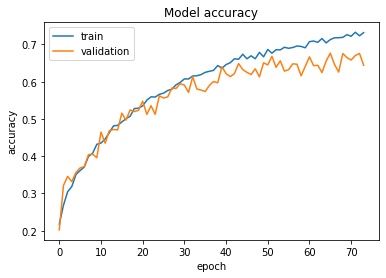

In [43]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

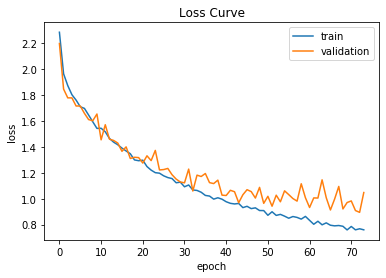

In [44]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Curve')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()